# **Paul Badu Yakubu**  

## Caltech AI/ML Bootcamp
### Machine Learning course-end project

---

# Employee Turnover Analytics

---

### **Project Statement**
**Portobello Tech** is an app innovator that has devised an intelligent way of predicting employee turnover within the company. It periodically evaluates employees' work details, including:

- Number of projects worked on
- Average monthly working hours
- Time spent in the company
- Promotions in the last 5 years
- Salary level

Data from prior evaluations also shows employee satisfaction at the workplace, which can be analyzed to identify patterns in work style and their interest in continuing to work in the company. The HR Department owns this data and uses it to predict employee turnover, defined as the total number of workers who leave a company over a certain time period.

As the **ML Developer** assigned to the HR Department, you have been tasked with developing ML programs to:
1. **Perform data quality checks**: Check for any missing values.
2. **Understand contributing factors**: Use Exploratory Data Analysis (EDA) to identify key factors driving employee turnover.
3. **Cluster employees**: Group employees who left based on their satisfaction and evaluation scores.
4. **Address class imbalance**: Use the SMOTE technique to balance the 'left' class.
5. **Train and evaluate models**: Perform k-fold cross-validation for robust model evaluation.
6. **Select the best model**: Justify the choice based on relevant evaluation metrics.
7. **Suggest retention strategies**: Recommend approaches to retain targeted employees.

---

### **Dataset Overview**

> **Source**: [Kaggle - HR Analytics Data](https://www.kaggle.com/liujiaqi/hr-comma-sepcsv)

The data contains various features related to employees’ work style, satisfaction, and historical data relevant to turnover analysis.

| **Column Name**          | **Description**                                                                                   |
|---------------------------|---------------------------------------------------------------------------------------------------|
| satisfaction_level        | Satisfaction level of an employee at their job                                                   |
| last_evaluation           | Rating (0 to 1) received by an employee at their last evaluation                                 |
| number_project            | Number of projects an employee is involved in                                                    |
| average_monthly_hours     | Average number of hours per month spent by an employee at the office                             |
| time_spend_company        | Number of years spent in the company                                                             |
| Work_accident             | `0` - no accident during employee's stay, `1` - accident occurred                                |
| left                      | `0` indicates employee stays, `1` indicates employee left                                        |
| promotion_last_5years     | Number of promotions during the employee's tenure                                                |
| Department                | Department to which an employee belongs                                                          |
| salary                    | Salary level in USD                                                                              |

---

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, LabelBinarizer
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report, multilabel_confusion_matrix
from sklearn.utils import resample
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve


In [87]:
df = pd.read_csv("HR_comma_sep.csv")
df.head()


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Data Preprocessing

In [88]:
#Check for missing values
df.isnull().sum().any()

False

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [90]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [91]:
df['sales'].unique()

array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
       'IT', 'product_mng', 'marketing', 'RandD'], dtype=object)

In [92]:
df['salary'].unique()

array(['low', 'medium', 'high'], dtype=object)

# Step 2: Exploratory Data Analysis (EDA)

---

### 2.1 Correlation Heatmap

To better understand the relationships between features, we’ll generate a **correlation matrix** and visualize it using a **heatmap**. This will help us identify strong positive or negative correlations, which can be useful in determining which features most influence employee turnover.


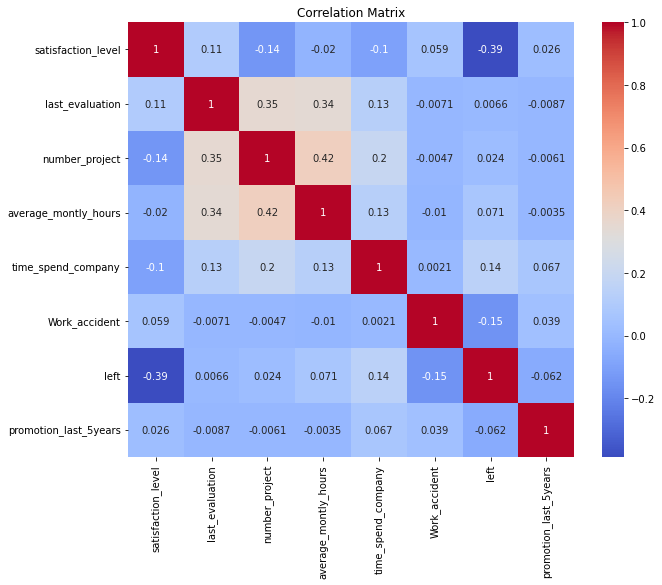

In [93]:
# Select numeric columns for correlation
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


# Correlation Matrix Analysis

In the correlation matrix below, each cell represents the correlation coefficient between two variables in the dataset. The values range from -1 to 1:

- **Values close to 1** indicate a strong positive correlation, meaning that as one variable increases, the other also increases.
- **Values close to -1** indicate a strong negative correlation, meaning that as one variable increases, the other decreases.
- **Values close to 0** suggest little or no correlation between the variables.

The color scheme visualizes these relationships, with **red hues** representing positive correlations and **blue hues** representing negative correlations.

## Key Observations

1. **Satisfaction Level vs. Left (-0.39)**  
   - There is a moderate negative correlation between employee satisfaction level and leaving the company. This implies that employees with lower satisfaction levels are more likely to leave.

2. **Last Evaluation vs. Number of Projects (0.35)**  
   - There is a moderate positive correlation between an employee’s last evaluation score and the number of projects they are involved in, suggesting that higher evaluations may be linked to higher involvement in projects.

3. **Number of Projects vs. Average Monthly Hours (0.42)**  
   - A positive correlation exists here, indicating that employees working on more projects tend to have higher average monthly working hours.

4. **Time Spent in Company vs. Number of Projects (0.20)**  
   - There is a mild positive correlation, suggesting that employees who have been with the company longer may be involved in more projects, though this correlation is relatively weak.

5. **Work Accident vs. Left (-0.15)**  
   - There’s a slight negative correlation between having a work accident and leaving the company, though this relationship is weak.

6. **Promotion in Last 5 Years vs. Left (-0.062)**  
   - This weak negative correlation implies that employees with recent promotions are slightly less likely to leave, although the correlation is quite small.

## Summary

From the matrix, **satisfaction level** appears to be the most influential factor in predicting whether an employee will leave, as it has the strongest (negative) correlation with the `left` variable. This indicates that job satisfaction is a crucial factor in employee turnover within this dataset. Other factors, such as **number of projects** and **average monthly hours**, also have moderate correlations with each other but have weaker relationships with turnover.


### 2.2 Distribution Plots
We'll plot the distribution of satisfaction_level, last_evaluation, and average_montly_hours.

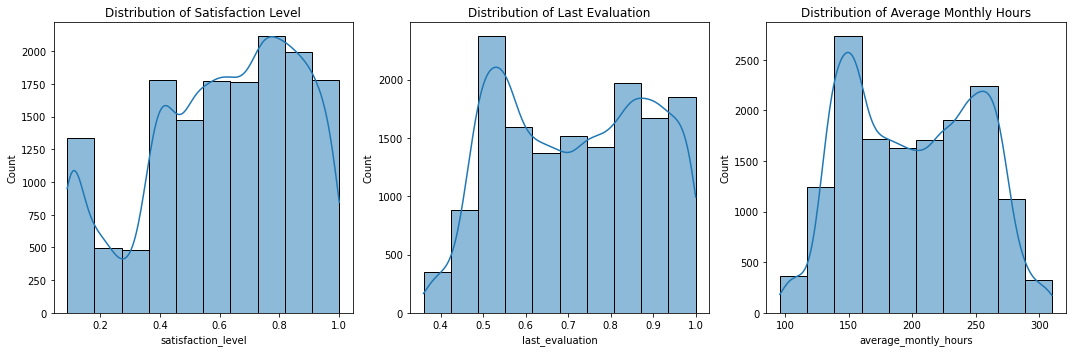

In [94]:
# Plot distributions
plt.figure(figsize=(15, 5))

# Satisfaction Level
plt.subplot(1, 3, 1)
sns.histplot(df['satisfaction_level'], kde=True, bins=10)
plt.title("Distribution of Satisfaction Level")

# Last Evaluation
plt.subplot(1, 3, 2)
sns.histplot(df['last_evaluation'], kde=True, bins=10)
plt.title("Distribution of Last Evaluation")

# Average Monthly Hours
plt.subplot(1, 3, 3)
sns.histplot(df['average_montly_hours'], kde=True, bins=10)
plt.title("Distribution of Average Monthly Hours")

plt.tight_layout()
plt.show()

# Distribution Analysis

The graphs above shows the distributions of three key variables related to employee behavior and performance: **Satisfaction Level**, **Last Evaluation**, and **Average Monthly Hours**.

## 1. Distribution of Satisfaction Level
- The distribution of satisfaction levels is fairly spread across the scale, with most values falling between 0.5 and 0.8.
- There are noticeable peaks at certain intervals, suggesting clusters of employees with similar satisfaction scores.
- A higher number of employees have satisfaction levels around 0.6-0.8, while fewer employees have extreme low or high satisfaction levels (close to 0 or 1).

## 2. Distribution of Last Evaluation
- The last evaluation scores are also broadly distributed, with a significant concentration around the 0.5 mark.
- There is another peak around 0.9, suggesting that some employees received high evaluation scores.
- This bimodal distribution could indicate that employees are generally grouped into average and high evaluation categories.

## 3. Distribution of Average Monthly Hours
- The distribution of average monthly hours worked shows a peak around 150 hours, with another smaller peak near 250 hours.
- This bimodal distribution suggests two groups of employees: those who work fewer hours (close to 150) and those who work more hours (around 250).
- The distribution tapers off at the extremes (below 100 and above 300 hours), indicating that most employees fall within a standard range of monthly working hours.

The distributions reveal that:
- **Satisfaction Levels** are varied, with most employees feeling moderately satisfied.
- **Evaluation Scores** are clustered around two main points, potentially separating average and high-performing employees.
- **Average Monthly Hours** also shows two peaks, possibly representing employees with different work intensity or roles.

These insights are valuable for identifying patterns that could influence employee turnover and job satisfaction, helping HR better understand workforce dynamics.


### 2.3 Project Count Bar Plot
We'll create a bar plot showing the number of projects completed by employees who stayed vs. those who left.

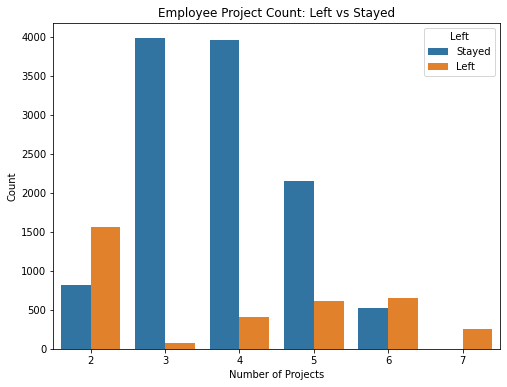

In [95]:
# Project count bar plot
plt.figure(figsize=(8, 6))
sns.countplot(x='number_project', hue='left', data=df)
plt.title("Employee Project Count: Left vs Stayed")
plt.xlabel("Number of Projects")
plt.ylabel("Count")
plt.legend(title="Left", labels=["Stayed", "Left"])
plt.show()

# Employee Project Count: Left vs. Stayed

The bar plot above illustrates the distribution of employees who **left** versus those who **stayed** based on the **number of projects** they worked on.

## Observations

1. **Employees with 3 or 4 Projects**:
   - The majority of employees worked on either 3 or 4 projects.
   - Among these, very few left the company, indicating that employees with a moderate project load are more likely to stay.

2. **Employees with 2 Projects**:
   - A significant portion of employees who worked on only 2 projects left the company.
   - This may suggest that employees with lower project involvement have a higher likelihood of turnover.

3. **Employees with 5 or More Projects**:
   - As the number of projects increases beyond 4, the number of employees who left also increases.
   - Notably, employees with 5, 6, or 7 projects show a higher proportion of turnover compared to those with 3 or 4 projects.
   - This trend suggests that a higher project load may correlate with a higher likelihood of leaving, possibly due to burnout or job dissatisfaction.

- Employees working on 3-4 projects are the least likely to leave, while those with fewer (2 projects) or more (5+ projects) show a higher tendency to leave.
- This pattern highlights the potential impact of project workload on employee retention, suggesting that an optimal number of projects may contribute to higher job satisfaction and retention.


# Step 3: Clustering of Employees Who Left

---
## 3.1 Select Relevant Features and 3.2 Apply K-means Clustering
We'll use K-means clustering on satisfaction_level and last_evaluation for employees who left.

/home/paul-fordham/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/paul-fordham/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/paul-fordham/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/paul-fordham/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will chang

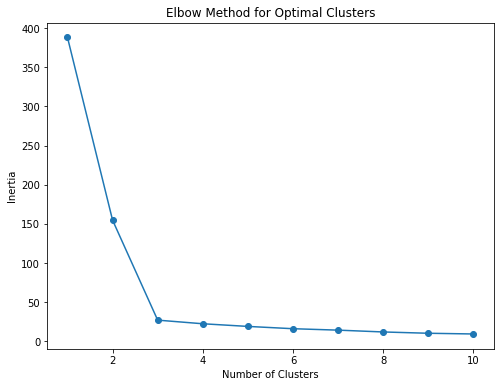

In [96]:
# Use satisfaction_level and last_evaluation of employees who left
X = left_df[['satisfaction_level', 'last_evaluation']]

# Calculate inertia for a range of cluster numbers
inertia = []
cluster_range = range(1, 11)  # Testing from 1 to 10 clusters

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal Clusters")
plt.show()


### The Elbow plot shows that the optimum number of clusters is 3

/home/paul-fordham/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/tmp/ipykernel_2729708/3815973357.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  left_df['cluster'] = kmeans.fit_predict(X)


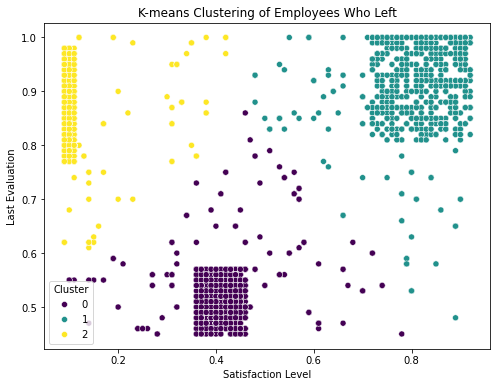

In [97]:
# Filter the dataset for employees who left
left_df = df[df['left'] == 1]

# Select satisfaction and evaluation columns
X = left_df[['satisfaction_level', 'last_evaluation']]

# Apply K-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
left_df['cluster'] = kmeans.fit_predict(X)

# Plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=left_df, x='satisfaction_level', y='last_evaluation', hue='cluster', palette="viridis")
plt.title("K-means Clustering of Employees Who Left")
plt.xlabel("Satisfaction Level")
plt.ylabel("Last Evaluation")
plt.legend(title="Cluster")
plt.show()

# K-means Clustering Analysis of Employees Who Left

The scatter plot above shows the results of **K-means clustering** applied to employees who left the company, based on **Satisfaction Level** and **Last Evaluation** scores. The data points are grouped into three distinct clusters, represented by different colors.

## Cluster Interpretation

1. **Cluster 1 (Purple)**:
   - **Low Satisfaction (around 0.3 - 0.4)** and **Moderate to Low Evaluation Scores (around 0.5 - 0.7)**.
   - This cluster likely represents employees who were **dissatisfied with their job** and **received average or below-average evaluations**.
   - High turnover is expected in this group due to low satisfaction and potentially stagnant career growth, which could lead to disengagement.

2. **Cluster 2 (Green)**:
   - **High Satisfaction (0.7 - 1.0)** and **High Evaluation Scores (around 0.7 - 1.0)**.
   - These employees exhibit **both high satisfaction and high evaluation scores**.
   - Their departure might be attributed to factors outside of work performance or satisfaction, possibly related to external opportunities or personal circumstances.

3. **Cluster 3 (Yellow)**:
   - **Low Satisfaction (0.1 - 0.3)** and **High Evaluation Scores (around 0.8 - 1.0)**.
   - Employees in this cluster appear to have **high performance as indicated by their evaluations**, but **low satisfaction** with their job.
   - This group may represent **high performers experiencing burnout or job dissatisfaction**, possibly due to high workloads, lack of rewards, or inadequate support, driving them to leave despite their strong evaluations.

## Findings

- **Cluster 1** indicates a group of disengaged employees with average performance, suggesting they left due to dissatisfaction and limited career progress.
- **Cluster 2** represents well-performing, satisfied employees, whose departure might not be directly work-related.
- **Cluster 3** suggests a group of high-performing employees who left due to dissatisfaction, likely caused by burnout or unmet expectations.

These insights can help the company tailor **retention strategies** to address each group's needs, such as improving career development opportunities for Cluster 1, re-engaging Cluster 3 with better work-life balance, and understanding external factors for Cluster 2.

# Step 4: Handle Class Imbalance Using SMOTE
---
## 4.1 Preprocess Data (Convert Categorical Variables)
We'll separate categorical and numerical variables, encode categorical columns, and then combine them.

In [98]:
# Convert categorical variables using pd.get_dummies
df_encoded = pd.get_dummies(df, columns=['sales', 'salary'], drop_first=True)

# Separate features and target variable
X = df_encoded.drop('left', axis=1)
y = df_encoded['left']

# Stratified train-test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

# Apply SMOTE to balance classes in the training set
smote = SMOTE(random_state=123)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Original class distribution:\n", y.value_counts())
print("\nResampled class distribution:\n", y_train_smote.value_counts())

Original class distribution:
 left
0    11428
1     3571
Name: count, dtype: int64

Resampled class distribution:
 left
0    9142
1    9142
Name: count, dtype: int64


# Step 5: 5-Fold Cross-Validation Model Training and Evaluation
---
## 5.1 Train and Evaluate Models
We'll train three models—Logistic Regression, Random Forest, and Gradient Boosting Classifier—using 5-fold cross-validation and display the classification report for each.

In [99]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train_smote)

# transform the test data
X_test_scaled = scaler.transform(X_test)

In [100]:
X_train_scaled

array([[-1.52244602, -1.81291354,  0.8495604 , ..., -0.50957082,
         0.91995065, -0.84988585],
       [-1.74859559,  0.52692259,  1.54834858, ..., -0.50957082,
         0.91995065, -0.84988585],
       [ 0.06060097, -1.2558097 , -1.24680413, ..., -0.50957082,
         0.91995065, -0.84988585],
       ...,
       [-1.6732124 ,  0.57753051,  1.54834858, ..., -0.50957082,
         0.91995065, -0.84988585],
       [ 0.70032666,  1.07200446,  0.8495604 , ..., -0.50957082,
        -1.08701483,  1.17662861],
       [-0.45308705, -0.84115325, -1.24680413, ..., -0.50957082,
        -1.08701483,  1.17662861]])

In [101]:
y_train_smote

0        0
1        1
2        0
3        0
4        0
        ..
18279    1
18280    1
18281    1
18282    1
18283    1
Name: left, Length: 18284, dtype: int64

In [148]:
# Function to evaluate a model with 5-fold CV and plot classification report
def evaluate_model_with_cv(model, model_name, X_train, y_train):
    print(f"Training {model_name} with 5-fold CV...")
    
    # Perform cross-validation using F1-score
    cv_results = cross_val_score(model, X_train_scaled, y_train_smote, cv=5, scoring='f1')
    print(f"{model_name} 5-Fold CV F1-Score: {cv_results.mean():.3f}")
    
    # Predict using cross-validation
    y_pred_cv = cross_val_predict(model, X_train_scaled, y_train_smote, cv=5)
    
    # Print classification report
    print(f"\nClassification Report for {model_name} (5-Fold CV):")
    print(classification_report(y_train, y_pred_cv))
    
    # Plotting classification report as heatmap
    report = classification_report(y_train_smote, y_pred_cv, output_dict=True)
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Blues')
    plt.title(f"{model_name} - Classification Report (5-Fold CV)")
    plt.show()


## 5.1 Logistic Regression Classification Report

Training Logistic Regression with 5-fold CV...
Logistic Regression 5-Fold CV F1-Score: 0.798

Classification Report for Logistic Regression (5-Fold CV):
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      9142
           1       0.78      0.82      0.80      9142

    accuracy                           0.80     18284
   macro avg       0.80      0.80      0.80     18284
weighted avg       0.80      0.80      0.80     18284



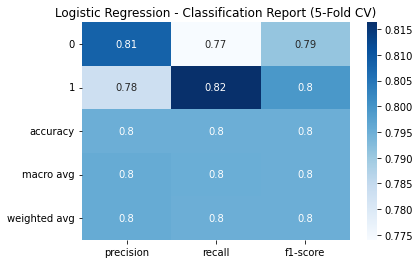

In [149]:
# Define models
logistic_model = LogisticRegression(max_iter=1000, random_state=123)

# Train and evaluate each model
evaluate_model_with_cv(logistic_model, "Logistic Regression", X_train_scaled, y_train_smote)

## Performance Analysis of Logistic Regression Model

### 1. Classification Report
In this model, Class 0(stayed) has slightly higher precision (0.81) but lower recall (0.77), while Class 1(Left) has higher recall (0.82) but slightly lower precision (0.78). Overall accuracy is 80%, meaning 80% of predictions are correct.

## 5.2 Random Forest Classification Report

Training Random Forest with 5-fold CV...
Random Forest 5-Fold CV F1-Score: 0.984

Classification Report for Random Forest (5-Fold CV):
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      9142
           1       1.00      0.97      0.98      9142

    accuracy                           0.98     18284
   macro avg       0.98      0.98      0.98     18284
weighted avg       0.98      0.98      0.98     18284



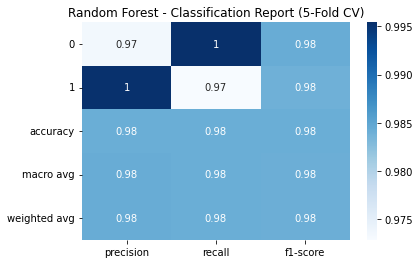

In [150]:
random_forest_model = RandomForestClassifier(random_state=123)
evaluate_model_with_cv(random_forest_model, "Random Forest", X_train_scaled, y_train_smote)


### Classification Report for Random Forest
The classification report provides several metrics for evaluating the performance of the Random Forest classifier. The metrics are broken down by class (0 and 1) and include precision, recall, and F1-score. Additionally, overall metrics such as accuracy, macro average, and weighted average are provided.

- **Precision**: The ratio of correctly predicted positive observations to the total predicted positives. For class 0, the precision is 0.97, and for class 1, it is 1.0.
- **Recall**: The ratio of correctly predicted positive observations to all observations in the actual class. For class 0, the recall is 1.0, and for class 1, it is 0.97.
- **F1-score**: The weighted average of precision and recall. For class 0, the F1-score is 0.98, and for class 1, it is 0.98.
- **Accuracy**: The ratio of correctly predicted observations to the total observations. The accuracy is 0.98.
- **Macro average**: The average of precision, recall, and F1-score for all classes. The macro average for precision, recall, and F1-score is 0.98.
- **Weighted average**: The average of precision, recall, and F1-score, weighted by the number of true instances for each class. The weighted average for precision, recall, and F1-score is 0.98.

The Random Forest classifier's performance, highlighting its high accuracy and balanced precision, recall, and F1-scores across both classes.

## 5.3 Gradient Boosting Classification Report

Training Gradient Boosting with 5-fold CV...
Gradient Boosting 5-Fold CV F1-Score: 0.962

Classification Report for Gradient Boosting (5-Fold CV):
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      9142
           1       0.98      0.95      0.96      9142

    accuracy                           0.96     18284
   macro avg       0.96      0.96      0.96     18284
weighted avg       0.96      0.96      0.96     18284



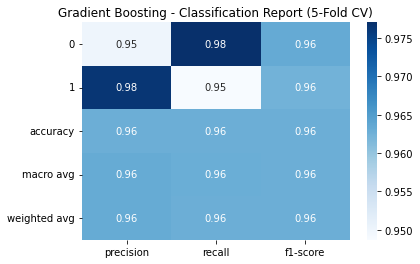

In [152]:
gradient_boosting_model = GradientBoostingClassifier(random_state=123)
evaluate_model_with_cv(gradient_boosting_model, "Gradient Boosting", X_train_scaled, y_train_smote)

#### Classification Report for Gradient Boosting
The classification report provides several metrics for evaluating the performance of the Gradient Boosting classifier. The metrics are broken down by class (0 and 1) and include precision, recall, and F1-score. Additionally, overall metrics such as accuracy, macro average, and weighted average are provided.

- **Precision**: The ratio of correctly predicted positive observations to the total predicted positives. For class 0, the precision is 0.95, and for class 1, it is 0.98.
- **Recall**: The ratio of correctly predicted positive observations to all observations in the actual class. For class 0, the recall is 0.98, and for class 1, it is 0.95.
- **F1-score**: The weighted average of precision and recall. For both classes, the F1-score is 0.96.
- **Accuracy**: The ratio of correctly predicted observations to the total observations. The accuracy is 0.96.
- **Macro average**: The average of precision, recall, and F1-score for all classes. The macro average for precision, recall, and F1-score is 0.96.
- **Weighted average**: The average of precision, recall, and F1-score, weighted by the number of true instances for each class. The weighted average for precision, recall, and F1-score is 0.96.

The Gradient Boosting classifier's performance, highlighting its high accuracy and balanced precision, recall, and F1-scores across both classes.

# 6. Identify the best model and justify the evaluation metrics used
---
### 6.1. Find the ROC/AUC (area under ROC curve)  for each of the 3 models from the and plot the ROC curve

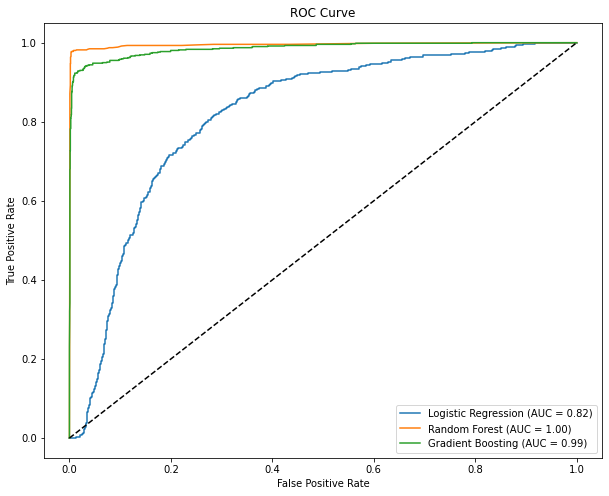

In [106]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=123),
    'Random Forest': RandomForestClassifier(random_state=123),
    'Gradient Boosting': GradientBoostingClassifier(random_state=123)
}

plt.figure(figsize=(10, 8))
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train_smote)  # Fit model
    y_proba = model.predict_proba(X_test_scaled)[:, 1]  # Predict probabilities
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# 6.2. Find the confusion matrix for each of the models

## Breakdown of each metric and its implications in this context:

### Key Confusion Matrix Metrics:
- **True Positives (TP)**: Employees correctly predicted to leave.
- **True Negatives (TN)**: Employees correctly predicted to stay.
- **False Positives (FP)**: Employees incorrectly predicted to leave (they actually stayed).
- **False Negatives (FN)**: Employees incorrectly predicted to stay (they actually left).

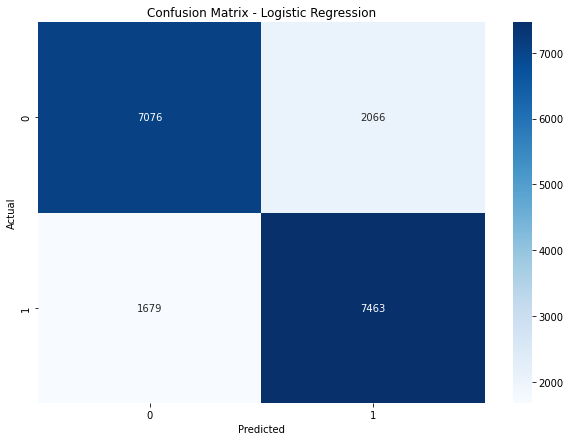

In [114]:
y_true = y_train_smote
y_pred = cross_val_predict(LogisticRegression(max_iter=1000, random_state=123), X_train_scaled, y_train_smote, cv=5)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


### Confusion Matrix for Logistic Regression
- **True Negatives (TN)**: 7076 cases correctly predicted as Class 0(stay).
- **False Positives (FP)**: 2066 cases incorrectly predicted as Class 1(left).
- **False Negatives (FN)**: 1679 cases incorrectly predicted as Class 0(stay).
- **True Positives (TP)**: 7463 cases correctly predicted as Class 1(left).

This analysis shows that the Logistics Regression model is balanced, with both classes receiving similar performance scores. However, the presence of false positives and false negatives indicates areas where the model could improve in distinguishing between the two classes accurately.

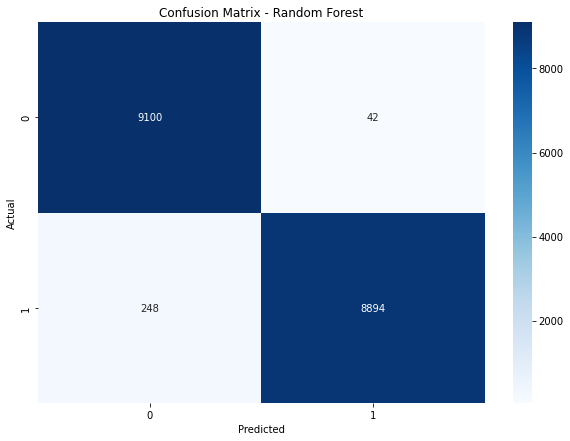

In [118]:
# Random Forest
y_pred_rf = cross_val_predict(RandomForestClassifier(random_state=123), X_train_scaled, y_train_smote, cv=5)
cm_rf = confusion_matrix(y_train_smote, y_pred_rf)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()


### Confusion Matrix for Random Forest
The confusion matrix shows the number of true positive, true negative, false positive, and false negative predictions made by the Random Forest classifier.

Here's a breakdown of each metric and its implications in this context:

### Key Confusion Matrix Metrics:
1. **True Positives (TP)**: Employees correctly predicted to leave.
2. **True Negatives (TN)**: Employees correctly predicted to stay.
3. **False Positives (FP)**: Employees incorrectly predicted to leave (they actually stayed).
4. **False Negatives (FN)**: Employees incorrectly predicted to stay (they actually left).

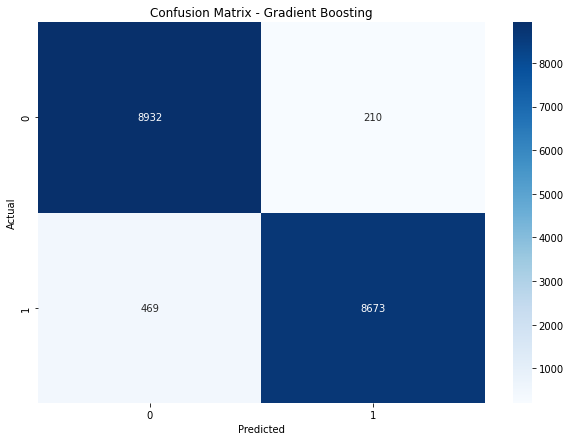

In [120]:
# Gradient Boosting
y_pred_gb = cross_val_predict(GradientBoostingClassifier(random_state=123), X_train_scaled, y_train_smote, cv=5)
cm_gb = confusion_matrix(y_train_smote, y_pred_gb)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Gradient Boosting')
plt.show()

#### Confusion Matrix for Gradient Boosting
The confusion matrix shows the number of true positive, true negative, false positive, and false negative predictions made by the Gradient Boosting classifier.

- **True Negatives (TN)**: 8932 instances of class 0 were correctly predicted as class 0.
- **False Positives (FP)**: 210 instances of class 0 were incorrectly predicted as class 1.
- **False Negatives (FN)**: 469 instances of class 1 were incorrectly predicted as class 0.
- **True Positives (TP)**: 8673 instances of class 1 were correctly predicted as class 1.

## Confusion Matrix Analysis
Plot the confusion matrix for each model to analyze performance.

In [140]:
# Logistic Regression
y_pred_lr = cross_val_predict(LogisticRegression(max_iter=1000, random_state=123), X_train_smote, y_train_smote, cv=5)
cm_lr = confusion_matrix(y_train_smote, y_pred_lr)
print("Confusion Matrix - Logistic Regression:")
print(cm_lr)

# Random Forest
y_pred_rf = cross_val_predict(RandomForestClassifier(random_state=123), X_train_smote, y_train_smote, cv=5)
cm_rf = confusion_matrix(y_train_smote, y_pred_rf)
print("Confusion Matrix - Random Forest:")
print(cm_rf)

# Gradient Boosting
y_pred_gb = cross_val_predict(GradientBoostingClassifier(random_state=123), X_train_smote, y_train_smote, cv=5)
cm_gb = confusion_matrix(y_train_smote, y_pred_gb)
print("Confusion Matrix - Gradient Boosting:")
print(cm_gb)

Confusion Matrix - Logistic Regression:
[[7067 2075]
 [1679 7463]]
Confusion Matrix - Random Forest:
[[9100   42]
 [ 251 8891]]
Confusion Matrix - Gradient Boosting:
[[8932  210]
 [ 469 8673]]


# 6.3. Explain which metric needs to be used from the confusion matrix - Recall or Precision?

Because the goal is to predict employee turnover (`left` column as the target label), the choice between **precision** and **recall** depends on the specific goals of the business and the cost of different types of prediction errors.

### Metric Explanation:
- **Precision** in this context measures the accuracy of the model's predictions for employees who are predicted to leave. Higher precision indicates fewer false positives (incorrectly predicting someone will leave when they will actually stay).
  - **Use Case**: Precision is critical if we want to ensure that when the model flags an employee as likely to leave, there’s high confidence in this prediction. This may be relevant if, for instance, reaching out to potentially leaving employees requires significant resources, and we want to avoid unnecessary interventions.

- **Recall** measures the model’s ability to identify all employees who are likely to leave. Higher recall indicates fewer false negatives (failing to identify employees who actually left).
  - **Use Case**: Recall is crucial if it’s more important to identify as many employees at risk of leaving as possible, even if it means some false alarms (false positives). This could be relevant if employee turnover is costly, and missing a potentially leaving employee has a high impact.

### Recommended Metric: **Recall**
In most employee turnover scenarios, **recall** is typically prioritized over precision because:
- Missing an employee who is likely to leave (false negative) can have significant costs, as employee turnover can lead to expenses for recruitment, training, and productivity loss.
- Capturing as many potentially leaving employees as possible (even if some predictions are incorrect) allows HR to take preventive action, such as offering career development opportunities, incentives, or other retention strategies.

### Conclusion:
For predicting employee turnover, **recall** is generally more important than precision. High recall ensures that the model identifies the majority of employees at risk of leaving, giving the organization a chance to intervene before they actually leave.

# 6.4. Identify the best model as the one with the highest metric defined above

In [155]:
# Function to evaluate a model with 5-fold CV and return recall
def evaluate_model_with_rc(model, model_name, X_train_scaled, y_train_smote):
    # Perform cross-validation using recall
    cv_results = cross_val_score(model, X_train_scaled, y_train_smote, cv=5, scoring='recall')
    
    # Predict using cross-validation
    y_pred_cv = cross_val_predict(model, X_train_scaled, y_train_smote, cv=5)
    
    # Get recall from classification report
    report = classification_report(y_train_smote, y_pred_cv, output_dict=True)
    recall = report['weighted avg']['recall']
    
    # Return results for storing in the table
    return model_name, cv_results.mean(), recall

# Initialize the models
logreg = LogisticRegression()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()

# Evaluate models
models = [logreg, rf, gb]
model_names = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']

# Store the results in a list
results = []

for model, model_name in zip(models, model_names):
    model_name, cv_recall, report_recall = evaluate_model_with_rc(model, model_name, X_train_scaled, y_train_smote)
    results.append([model_name, cv_recall, report_recall])

# Convert the results to a pandas DataFrame
results_df = pd.DataFrame(results, columns=['Model', '5-Fold CV Recall', 'Classification Report Recall'])

# Print the results in tabular form
print(results_df)


                 Model  5-Fold CV Recall  Classification Report Recall
0  Logistic Regression          0.816333                      0.795176
1        Random Forest          0.972763                      0.984139
2    Gradient Boosting          0.948697                      0.962864


# Random Forest is the best model because it achieved 98% of Recall with 5-Fold Cross Validation

## Step 7: Retention Strategies Based on Risk Zones
#### 7.1 Predict Turnover Probability and Categorize Employees
### Using the best model (Random Forest), we’ll predict turnover probability and assign employees to risk zones.

In [165]:
# The best model is Random Forest (adjust according to your results)
best_model = RandomForestClassifier()

# Fit the best model on the training data
best_model.fit(X_train_scaled, y_train_smote)

# Predict probabilities on the test data
probabilities = best_model.predict_proba(X_test_scaled)

# probabilities is a 2D array where each row corresponds to the predicted probabilities 
# for each class, e.g., [prob_class_0, prob_class_1], with prob_class_1 being the 
# probability of the employee turnover (class 1)

# To get the probability of turnover (class 1), we will extract the second column
turnover_probabilities = probabilities[:, 1]

# Print the predicted probabilities for the test data
print("Predicted probabilities of employee turnover (class 1):")
print([turnover_probabilities])


Predicted probabilities of employee turnover (class 1):
[array([0.  , 0.6 , 0.05, ..., 0.03, 0.03, 1.  ])]


In [170]:
predictions_df = pd.DataFrame({
    'Turnover Probability': turnover_probabilities
})

predictions_df


,Turnover Probability
0,0.00
1,0.60
2,0.05
3,0.00
4,0.00
...,...
2995,0.00
2996,0.05
2997,0.03
2998,0.03


In [186]:
# Turnover_probabilities contains the predicted probabilities of turnover (class 1) for each employee

# Function to categorize employees based on their probability
def categorize_zone(prob):
    if prob < 0.20:
        return 'Safe'
    elif 0.20 <= prob < 0.60:
        return 'Low Risk'
    elif 0.60 <= prob < 0.90:
        return 'Medium Risk'
    else:
        return 'High Risk'

# Apply the categorization function to the 'Turnover Probability' column
predictions_df['Zone'] = predictions_df['Turnover Probability'].apply(categorize_zone)

# Display the updated DataFrame with Zones
predictions_df.head(20)

,Turnover Probability,Zone
0,0.00,Safe
1,0.60,Medium Risk
2,0.05,Safe
3,0.00,Safe
4,0.00,Safe
5,0.02,Safe
6,0.00,Safe
7,0.00,Safe
8,0.00,Safe
9,0.01,Safe


In [182]:
predictions_df['Zone'].value_counts()

Zone
Safe           2172
High Risk       657
Low Risk        124
Medium Risk      47
Name: count, dtype: int64

### Employee Retention Strategies by Risk Zone

Based on the probability of employee turnover, employees can be categorized into four zones. Here are the tailored retention strategies for each zone:

---

#### 1. **Safe Zone (Green) - 2172 Employees**  
**Characteristics:** Very low probability of turnover.  
**Retention Strategy:**
- **Recognition & Rewards:** Continue recognizing achievements with rewards (bonuses, team outings, etc.).
- **Career Development:** Offer training, mentorship, and growth opportunities.
- **Wellness Programs:** Promote work-life balance and health-related benefits.
- **Engagement Surveys:** Regular feedback to ensure their needs are met.

---

#### 3. **Low Risk Zone (Yellow) - 124 Employees**  
**Characteristics:** Moderate risk of leaving. Could be engaged with the right opportunities.  
**Retention Strategy:**
- **Skill Development:** Provide opportunities for professional upskilling.
- **Career Path Clarity:** Ensure clear advancement opportunities.
- **Engagement Activities:** Foster team-building and involvement in company decisions.
- **Work-Life Balance:** Offer flexible working options and wellness programs.
- **Feedback Channels:** Open communication to address underlying issues.

---

#### 4. **Medium Risk Zone (Orange) - 47 Employees**  
**Characteristics:** High chance of leaving. Needs immediate attention.  
**Retention Strategy:**
- **Immediate Intervention:** Personalized discussions to understand dissatisfaction.
- **Increased Engagement:** Get them involved in special projects or decision-making.
- **Compensation & Benefits:** Ensure competitive pay and benefits.
- **Team Dynamics:** Address any team conflicts or interpersonal issues.
- **Regular Check-ins:** Monitor their satisfaction regularly.

---

#### 2. **High Risk Zone (Red) - 657 Employees**  
**Characteristics:** Very high probability of turnover. Immediate intervention needed.  
**Retention Strategy:**
- **One-on-One Check-ins:** Address individual concerns through personalized meetings.
- **Job Role & Workload Adjustments:** Offer more meaningful responsibilities or reduce workload stress.
- **Recognition & Motivation:** Increase recognition and provide incentives.
- **Work Environment:** Tackle toxic culture or leadership issues.
- **Salary & Benefits Review:** Review and improve compensation packages.

---

### Summary:
- **Safe Zone**: Focus on recognition, career development, and maintaining engagement.
- **High Risk Zone**: Immediate personalized interventions, improve compensation, and address work environment.
- **Low Risk Zone**: Offer skill development, clear career paths, and work-life balance.
- **Medium Risk Zone**: Engage through regular check-ins, team integration, and compensation reviews.

Tailoring strategies to each group can reduce turnover and improve overall employee satisfaction.